In [2]:
# imports
# processing data
import pandas as pd
import numpy as np

# analysis
import statsmodels.formula.api as smf
from scipy.stats import entropy

# plot
import matplotlib.pyplot as plt
from d3blocks import D3Blocks
import seaborn as sns
import plotly.express as px

# misc
import warnings
import random
warnings.filterwarnings('ignore')

# Section 1: preprocessing data.

In [38]:
# Please add all preprocessing code here.

# loading imdb actor information
actors_raw = pd.read_csv('data/name.basics.tsv', sep='\t')

# filter out rows with missing data cruical for analysis
actors_raw = actors_raw[actors_raw["birthYear"] != r"\N"]

# loading imdb's principals
principals_raw = pd.read_csv('data/title.principals.tsv', sep='\t')

## Filter for leading actors and add column for gender
Filter for leading actors based on imdb's principals data which contains for each movie the most important people (i. e. actors, actress, directors etc.). The importance is given by imdb and stored in the 'ordering' column

In [ ]:

# filter for actors and actress in principals
principals = principals_raw[(principals_raw["category"] == "actress") | (principals_raw["category"] == "actor")] 

# add gender column (0=male, 1=female)
principals["gender"] = 0
principals.loc[principals["category"] == "actress", "gender"] = 1

# select ony important columns of principal and actors data set and join them left
principal_actors = principals[["tconst", "ordering", "nconst", "gender"]].merge(actors_raw[["nconst",	"primaryName",	"birthYear", "deathYear"]], how="left", on="nconst")

# Find total number of movies played by every leading actor
principal_actors.drop(columns=["deathYear"], inplace=True)
unique_actors = principal_actors["nconst"].unique()

male_actors = principal_actors[principal_actors["gender"] == 0]["nconst"].unique()
female_actors = principal_actors[principal_actors["gender"] == 1]["nconst"].unique()

In [40]:
# groupby actors
total_actor_experience = principal_actors.groupby(["nconst"]).count()
actor_to_experience = {}
for row in total_actor_experience.iterrows():
    actor_to_experience[row[0]] = row[1]["tconst"]

principal_actors.dropna(inplace=True)
principal_actors.head()

,tconst,ordering,nconst,gender,primaryName,birthYear
0,tt0000005,1,nm0443482,0,Charles Kayser,1878
1,tt0000005,2,nm0653042,0,John Ott,1850
2,tt0000007,1,nm0179163,0,James J. Corbett,1866
3,tt0000007,2,nm0183947,0,Peter Courtney,1867
4,tt0000008,1,nm0653028,0,Fred Ott,1860


## Add column for age of actor during start of movie

In [ ]:
# load in movie data and select relevent columns: tconst and startYear
movies_raw = pd.read_csv("data/title.basics.tsv", sep="\t")[["tconst", "startYear", "genres"]]

# filter out rows with missing data cruical for analysis
movies_raw = movies_raw[movies_raw["startYear"] != r"\N"]

# join movie data with actors
actor_movie_combi = principal_actors.merge(movies_raw, how="left", on="tconst")

# cast year columns to numeric in order to calculate
actor_movie_combi["startYear"] = pd.to_numeric(actor_movie_combi["startYear"]) # errors parameter for the case when date not given
actor_movie_combi["birthYear"] = pd.to_numeric(actor_movie_combi["birthYear"]) # errors parameter for the case when date not given

# add age_at_movie_start column
actor_movie_combi["age_at_movie_start"] = actor_movie_combi["startYear"] - actor_movie_combi["birthYear"]

## Add column for imdb ratings

In [36]:
# load in imdb ratings
ratings_raw = pd.read_csv('data/title.ratings.tsv', sep='\t')

# add ratings to overall data set
actor_movie_combi = actor_movie_combi.merge(ratings_raw, how="left", on="tconst")
actor_movie_combi.head()

,tconst,ordering,nconst,gender,primaryName,birthYear,startYear,genres,age_at_movie_start,averageRating_x,numVotes_x,exp_so_far,averageRating_y,numVotes_y
0,tt7816420,1,nm1155956,0,Eadweard Muybridge,1830,1881.0,"Documentary,Short",51.0,5.2,466.0,0,5.2,466.0
1,tt1758563,1,nm1796515,0,Adolphe Le Prince,1872,1888.0,"Documentary,Short",16.0,5.5,1338.0,0,5.5,1338.0
2,tt0416047,1,nm1362928,0,Giuseppe Sacco Albanese,1872,1890.0,Short,18.0,4.2,427.0,0,4.2,427.0
3,tt0416046,1,nm1362928,0,Giuseppe Sacco Albanese,1872,1890.0,Short,18.0,4.8,1111.0,1,4.8,1111.0
4,tt0361921,1,nm1362928,0,Giuseppe Sacco Albanese,1872,1890.0,"Documentary,Short",18.0,5.0,1512.0,2,5.0,1512.0


## Add column for number of movies an actor has been in before start of respective movie

In [ ]:
actor_movie_combi["exp_so_far"] = 0
actor_movie_combi.sort_values(by="startYear", inplace=True, ascending=True)
from collections import defaultdict
exp_so_far = defaultdict(int)
for row in actor_movie_combi.iterrows():
    actor = row[1]["nconst"]
    actor_movie_combi.loc[row[0], "exp_so_far"] = exp_so_far[actor]
    exp_so_far[actor] += 1

# # Drop rows with NA values and save to CSV
actor_movie_combi.dropna(inplace=True) 
actor_movie_combi.to_csv("data/actor_movie_combi.csv" , index=None)

# Defining functions to :
* Filter out movies from unwanted movie genres = ["Animation", "Biography", "Documentary","Short"] 
    * Animation - Only voice actors meanning that casting is heavily dictated by voice and language
    * Biography, Documentary - Heavily dependent on the subject
    * Short - We aim to study larger scale movies
* Study the genre density of the movie dataset
* Calculate the experience of actors per genre at the time of each movie release

In [42]:
pd.options.mode.chained_assignment = None  # default='warn'

# Broad range of genres taken into consideration
genres_major_add =  ['Drama', "Action", "Romance", "Comedy", "Adventure", "Crime", "War", "Family", "Mystery"]

# remove genres which do not have a strict relation to actor features in general
genres_remove = ["Animation", "Biography", "Documentary", "Short"]

# build features representing actor's experience of different movie genres.
def genre_exp(dataset, actor_keyword = "nconst", genre_keyword = "genres"):

    for x in genres_major_add:
        genre_label = x+"_exp_so_far"
        dataset[genre_label] = 0
        genre_exp_so_far = defaultdict(int)

        for row in dataset.iterrows():
            actor = row[1][actor_keyword]
            genres = row[1][genre_keyword].split(",")

            if x in genres:
                genre_exp_so_far[actor] += 1


            dataset.loc[row[0], genre_label] = genre_exp_so_far[actor]

    return dataset


# function removes certain genres and makes additional columns for each major genre marking which category the movie belongs to 

def extract_genres(dataset, genres_major=genres_major, genres_remove=genres_remove, genre_keyword ='genres', year_keyword='startYear'):

    x = []
    a = []


    # filter genres that we are not considering = [short, documentary, biography, animation]
    dataset_filtered = dataset[~dataset[genre_keyword].str.contains('|'.join(genres_remove))]

    # to store only movies and actors that have worked in the major genres
    movies_major = dataset_filtered[dataset_filtered[genre_keyword].str.contains('|'.join(genres_major))]

    # for i in genres_major:

    #     movies_major[i] = movies_major[genre_keyword].apply(lambda x: 1 if i in x else 0)

    movies_major.sort_values(by=year_keyword, ascending=True)

    for y in movies_major[genre_keyword]:

        if type(y) == str:
            x+= y.split(",")

    genres_all, counts = np.unique(x, return_counts=True)
    fig1 = plt.figure()

    # count movie genres.
    genre_df = pd.DataFrame(list(zip(genres_all, counts)), columns=["genre", "count"])
    genre_df.sort_values('count',inplace=True, ascending = False)
    genre_df.reset_index(drop=True,inplace=True)
    genre_df.set_index('genre').plot(kind='bar', figsize=(13,4))

    fig2 = plt.figure(figsize=(9,9))
    df_draw = genre_df.copy()
    df_draw.loc[df_draw['count'] < 50000, 'genre'] = 'Others'

    exp = np.zeros(len(df_draw["genre"].unique()))
    exp[0:5] = 0.1

    df_draw = df_draw.groupby('genre')['count'].sum().reset_index()
    df_draw.sort_values('count',inplace=True, ascending = False)

    plt.pie(df_draw['count'], labels=df_draw['genre'], autopct='%.0f%%', explode=exp)
    plt.show()

    return genres_all, counts, movies_major

# Section 2: genre analysis

- 1. Feature engineering


- 2. Genre pattern evaluation.

In [3]:
# load data.
movie_data = pd.read_csv("data/actor_movie_combi.csv")
movie_data.head(-10)

,tconst,ordering,nconst,gender,primaryName,birthYear,deathYear,startYear,genres,deatYear,age_at_movie_start,averageRating,numVotes,exp_so_far,drama_exp_so_far,action_exp_so_far,romance_exp_so_far,comedy_exp_so_far
0,tt7816420,1,nm1155956,0,Eadweard Muybridge,1830.0,1904,1881.0,"Documentary,Short",1904.0,51.0,5.2,462.0,0,0,0,0,0
1,tt1758563,1,nm1796515,0,Adolphe Le Prince,1872.0,1901,1888.0,"Documentary,Short",1901.0,16.0,5.5,1333.0,0,0,0,0,0
2,tt0361921,1,nm1362928,0,Giuseppe Sacco Albanese,1872.0,1943,1890.0,"Documentary,Short",1943.0,18.0,5.0,1508.0,0,0,0,0,0
3,tt0416047,1,nm1362928,0,Giuseppe Sacco Albanese,1872.0,1943,1890.0,Short,1943.0,18.0,4.2,425.0,1,0,0,0,0
4,tt0416046,1,nm1362928,0,Giuseppe Sacco Albanese,1872.0,1943,1890.0,Short,1943.0,18.0,4.8,1106.0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698931,tt7728792,2,nm6074154,0,Harry Hains,1992.0,2020,2022.0,Drama,2020.0,30.0,8.2,19.0,5,4,0,2,0
698932,tt21045916,3,nm0582378,0,Sombat Metanee,1937.0,2022,2022.0,"Drama,Romance",2022.0,85.0,10.0,5.0,16,2,9,2,4
698933,tt21045922,3,nm0582378,0,Sombat Metanee,1937.0,2022,2022.0,"Drama,Romance",2022.0,85.0,10.0,5.0,17,3,9,3,4
698934,tt21048302,2,nm7670169,0,Papangkorn Lerkchaleampote,1996.0,2022,2022.0,"Adventure,Drama,Thriller",2022.0,26.0,8.0,57.0,13,13,0,1,1


In [ ]:
%%capture
# pair-wise genre analysis
# we are interested in popular genres here.
target_genres = ["Drama", "Comedy", "Crime", "Action", "Romance", "Family", "Adventure", "Mystery", "War", "Musical", "Thriller"]
corr_matrix = np.zeros((len(target_genres), len(target_genres)))

# filter out movies with single genre.
multiple_genres_movie = movie_data[movie_data["genres"].str.contains(",")].reset_index()
for i in range(len(multiple_genres_movie)):
    for index1, first_genre in enumerate(target_genres):
        for index2, second_genre in enumerate(target_genres):
            if (first_genre != second_genre) and (first_genre in multiple_genres_movie["genres"][i]) and (second_genre in multiple_genres_movie["genres"][i]):
                corr_matrix[index1, index2] += 1

weight_matrix = [list(corr_matrix[genre_index, :]) for genre_index in range(len(target_genres))]
rows = []
for index1 in range(len(target_genres)):
    for index2 in range(index1, len(target_genres)):
        row = {
            "source": target_genres[index1],
            "target": target_genres[index2],
            "weight": weight_matrix[index1][index2],
        }
        row = pd.DataFrame(data=row, index=[0])
        rows.append(row)

matrix = pd.concat(rows)

# Initialize plot
d3 = D3Blocks()

# chord plot
d3.chord(matrix);

- 3. Correlation matrix of the background of actors (i.e., experience in each genre) to the genre of the movie he was filming.

In [9]:
# load data
movie_data = pd.read_csv("data/genre_experience_alive.csv")
movie_data.head(-5)

,Unnamed: 0,tconst,ordering,nconst,gender,primaryName,birthYear,deathYear,startYear,genres,...,comedy_exp_so_far,adventure_exp_so_far,crime_exp_so_far,war_exp_so_far,family_exp_so_far,mystery_exp_so_far,Drama,Action,Romance,Comedy
0,0,tt0000009,3,nm1309758,0,Chauncey Depew,1834.0,1928,1894.0,Romance,...,0,0,0,0,0,0,0,0,1,0
1,1,tt0000009,1,nm0063086,1,Blanche Bayliss,1878.0,1951,1894.0,Romance,...,0,0,0,0,0,0,0,0,1,0
2,2,tt0000009,2,nm0183823,0,William Courtenay,1875.0,1933,1894.0,Romance,...,0,0,0,0,0,0,0,0,1,0
3,3,tt1666737,1,nm0525908,0,Auguste Lumière,1862.0,1954,1896.0,"Action,Comedy,Family",...,2,0,0,0,1,0,0,1,0,1
4,4,tt0000211,1,nm0194945,1,Jehanne d'Alcy,1865.0,1956,1898.0,"Comedy,Fantasy,Horror",...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468542,468542,tt18351130,3,nm0430074,0,Leslie Jordan,1955.0,2022,2022.0,Comedy,...,99,4,18,0,1,0,0,0,0,1
468543,468543,tt18561180,3,nm0430074,0,Leslie Jordan,1955.0,2022,2022.0,Comedy,...,100,4,18,0,1,0,0,0,0,1
468544,468544,tt18568804,3,nm0430074,0,Leslie Jordan,1955.0,2022,2022.0,Comedy,...,101,4,18,0,1,0,0,0,0,1
468545,468545,tt7728792,2,nm6074154,0,Harry Hains,1992.0,2020,2022.0,Drama,...,0,0,0,0,0,0,1,0,0,0


In [10]:
genres = ["Drama", "Action", "Romance", "Comedy", "Crime", "War", "Family", "Mystery", "Adventure"]
corr_before_ongoing_genres = []
for genre in genres:
    movie_data_par_genre = movie_data[movie_data["genres"].str.contains(genre)]
    corr = movie_data_par_genre[["drama_exp_so_far", "action_exp_so_far", "romance_exp_so_far", "comedy_exp_so_far", "crime_exp_so_far", "war_exp_so_far", "family_exp_so_far", "mystery_exp_so_far", "adventure_exp_so_far"]].corr()
    corr_before_ongoing_genres.append(list(corr.loc[f"{genre.lower()}_exp_so_far"]))

In [12]:
# plot.
fig = px.imshow(corr_before_ongoing_genres,
                labels=dict(x="Actor's experience in each genre", y="Genre of the movie", color="correlation"),
                x=['Drama', 'Action', 'Romance', 'Comedy', 'Crime', 'War', 'Family', 'Mystery', 'Adventure'],
                y=['Drama', 'Action', 'Romance', 'Comedy', 'Crime', 'War', 'Family', 'Mystery', 'Adventure'],
                color_continuous_scale=px.colors.sequential.Cividis_r
               )
fig.update_xaxes(side="top")
fig.show()
# fig.write_html("./data/correlation_map.html")

# Section 3: Analysis of actors' features over time

In [65]:
movies_actor = pd.read_csv("data/actor_movie_combi.csv")

A confounder to consider: Actor experience and audience preference

The preferences of moviegoers can change over time. What may have been popular in one era may not be as popular in another. It’s important to consider how audience preferences may have changed over the different time periods we are analyzing. So let's see what we can find. We will divide our data into subgroups that depend on time periods (think baby boomer era vs gen Z era for example) to reduce the impact of the previously considered confounders; movies in the same time-period are much more likely to be made using similar technology and during comparable economic conditions. We can see how audience preference shifts through time by seeing how the top movies genres vary through time and which genres did actors gain most experience in


    Greatest Generation (born circa 1901 to 1924)
    Silent Generation (circa 1925 to 1945)
    Baby Boomers (circa 1946 to 1964)
    Generation X (circa 1965 to 1985)
    Millennial Generation (circa 1985 to 1996)
    Gen Z (post-Millennial) (circa 1997 to 2012)


In [7]:
greatest = movies_actor.loc[movies_actor["startYear"] <= 1924]

silent = movies_actor.loc[movies_actor["startYear"] >= 1925]
silent = silent.loc[silent["startYear"] <= 1945]

baby_boomers = movies_actor.loc[movies_actor["startYear"] >= 1945] 
baby_boomers = baby_boomers.loc[baby_boomers["startYear"] <= 1964]

boomers = movies_actor[movies_actor["startYear"] >= 1965]
boomers = boomers.loc[boomers["startYear"] <= 1985]

millennial = movies_actor[movies_actor["startYear"] >= 1986]
millennial = millennial.loc[millennial["startYear"] <= 1996]

gen_z = movies_actor[movies_actor["startYear"] >= 1997]
gen_z = gen_z[gen_z["startYear"] <= 2012]

gen_x = movies_actor[movies_actor["startYear"] >= 2013]

In [ ]:
all_data = [greatest, silent, baby_boomers, boomers, millennial, gen_z, gen_x]
labels = ["greatest_generation", "silent_generation", "baby_boomers", "boomers", "millennial", "gen_z", "gen_x"]

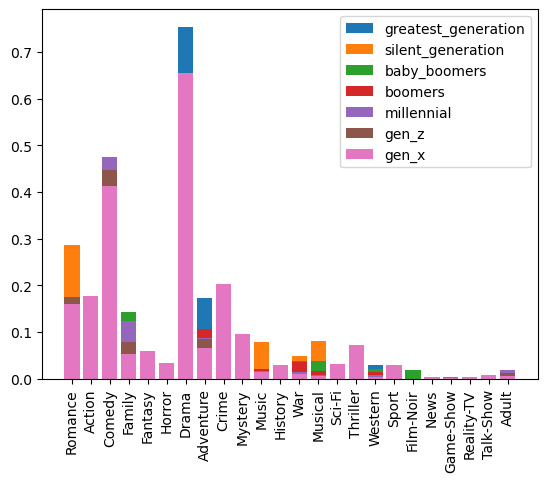

In [9]:
# Now we define the code to apply to every generation
def construct_top_genres(data, labelIndex):
    g = data["genres"].apply(lambda x: x.split(","))
    g = [item for sublist in g for item in sublist]
    from collections import Counter
    counts = Counter(g)
    x, y = [], []
    totalMovies = data["tconst"].count().sum()
    for key, val in counts.items():
        x.append(key)
        y.append(val/totalMovies)
        
    plt.bar(x, y, label=labels[labelIndex])
    plt.xticks(rotation=90)
    plt.legend()

for i, dataset in enumerate(all_data):
    construct_top_genres(dataset, i)

Gen_X sees a boom in the multitude of genres per movie released. In earlier years, there was less genres per movie on average. Let's see if that's true

The average number of genres per movie for greatest_generation is 1.87
The variance of the number of genres per movie for greatest_generation is 0.45 

The average number of genres per movie for silent_generation is 1.97
The variance of the number of genres per movie for silent_generation is 0.70 

The average number of genres per movie for baby_boomers is 1.84
The variance of the number of genres per movie for baby_boomers is 0.69 

The average number of genres per movie for boomers is 1.97
The variance of the number of genres per movie for boomers is 0.73 

The average number of genres per movie for millennial is 2.03
The variance of the number of genres per movie for millennial is 0.74 

The average number of genres per movie for gen_z is 2.12
The variance of the number of genres per movie for gen_z is 0.74 

The average number of genres per movie for gen_x is 2.20
The variance of the number of genres per movie for gen_x is 0.70 



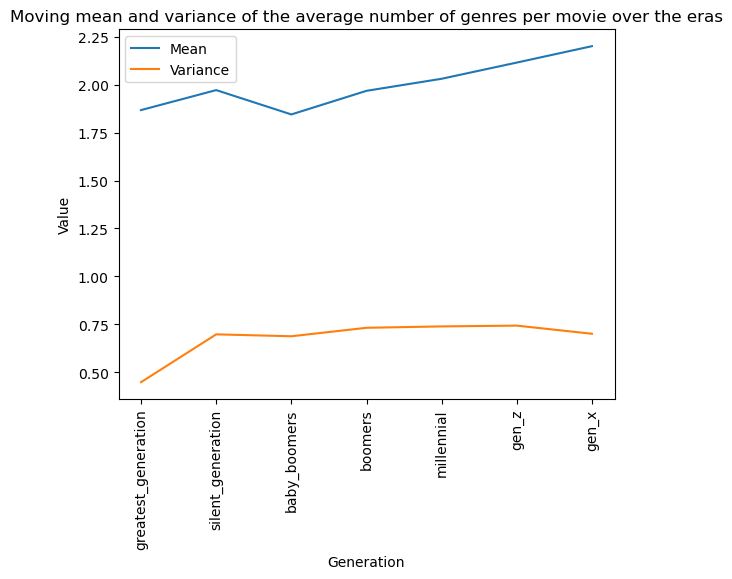

In [67]:
def find_mean_and_variance(data, labelIndex):
    l = data["genres"].apply(lambda x: len(x.split(","))).sum()
    numMovies = data["tconst"].count()

    average = l / numMovies
    averages.append(average)
    variance = np.var(data["genres"].apply(lambda x: len(x.split(","))))
    variances.append(variance)
    print(f"The average number of genres per movie for {labels[i]} is {average:.2f}")
    print(f"The variance of the number of genres per movie for {labels[i]} is {variance:.2f} \n")

averages = []
variances = []
for i, dataset in enumerate(all_data):
    find_mean_and_variance(dataset, i)

plt.plot(labels, averages, label='Mean')
plt.plot(labels, variances, label='Variance')
plt.xlabel("Generation")
plt.ylabel("Value")
plt.title("Moving mean and variance of the average number of genres per movie over the eras")
plt.xticks(rotation=90)
plt.legend()

## Visualise actor feature change over generations for each genre
Since weighting the average with any success metrics does not really matter, we are not considering a movie success metric for the following visuals. This means that we cannot say that those are the profiles of successfull actors.

In [62]:
movies_actor = pd.read_csv("data/actor_movie_combi_alive.csv")

Gen_X sees a boom in the multitude of genres per movie released. In earlier years, there was less genres per movie on average. Let's see if that's true

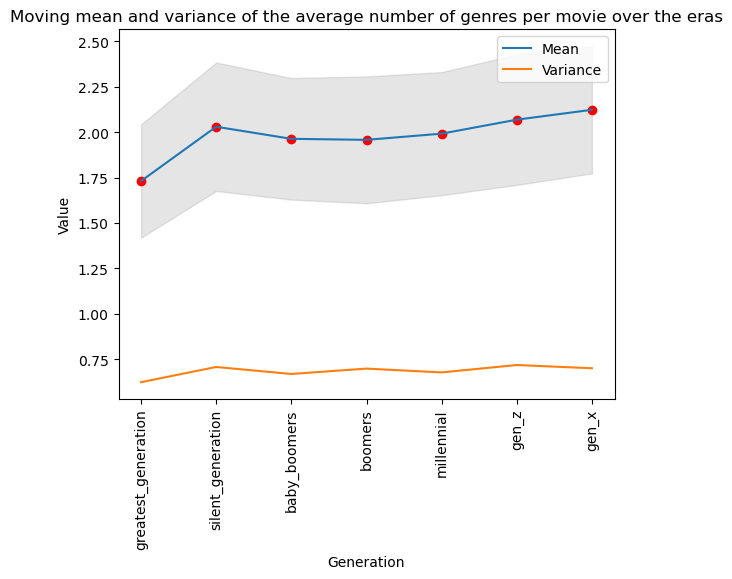

In [16]:
def find_mean_and_variance(data, labelIndex):
    l = data["genres"].apply(lambda x: len(x.split(","))).sum()
    numMovies = data["tconst"].count()

    average = l / numMovies
    averages.append(average)
    variance = np.var(data["genres"].apply(lambda x: len(x.split(","))))
    variances.append(variance)
    #print(f"The average number of genres per movie for {labels[i]} is {average:.2f}")
    #print(f"The variance of the number of genres per movie for {labels[i]} is {variance:.2f} \n")

averages = []
variances = []
for i, dataset in enumerate(all_data):
    find_mean_and_variance(dataset, i)

plt.plot(labels, averages, 'or')
plt.plot(labels, averages, label='Mean')
plt.fill_between(labels, averages - np.array(variances)/2, averages + np.array(variances)/2,color='gray', alpha=0.2)
plt.plot(labels, variances, label='Variance')
plt.xlabel("Generation")
plt.ylabel("Value")
plt.title("Moving mean and variance of the average number of genres per movie over the eras")
plt.xticks(rotation=90)
plt.legend()

Let's look at the average actor experience of actors per era

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

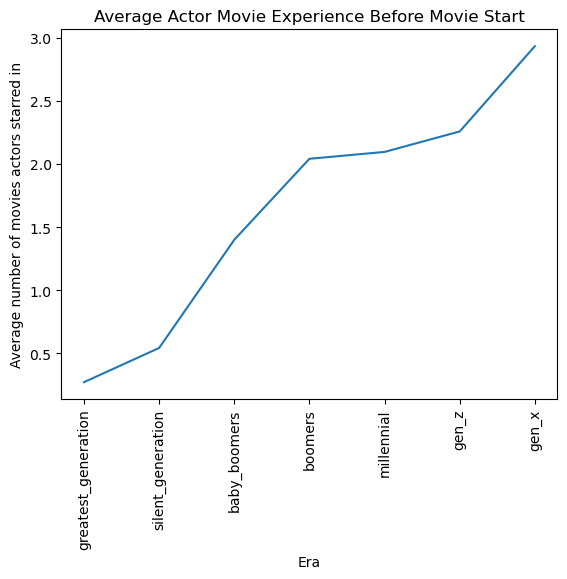

In [19]:
def plot_experience(data, labelIndex, key="exp_so_far"):
    total_exp = data[key].sum()
    total = data.size
    val = total_exp / total
    if key == "exp_so_far":
        avg.append(val)
    if key == "Drama_exp_so_far":
        drama_avg.append(val)
    if key == "Romance_exp_so_far":
        romance_avg.append(val)
    if key == "Action_exp_so_far":
        action_avg.append(val)
    if key == "Comedy_exp_so_far":
        comedy_avg.append(val)

avg = []
drama_avg = []
romance_avg = []
comedy_avg = []
action_avg = []

for i, dataset in enumerate(all_data):
    plot_experience(dataset, i)
    plot_experience(dataset, i, "Drama_exp_so_far")
    plot_experience(dataset, i, "Action_exp_so_far")
    plot_experience(dataset, i, "Comedy_exp_so_far")
    plot_experience(dataset, i, "Romance_exp_so_far")

plt.plot(labels, avg) 
plt.title("Average Actor Movie Experience Before Movie Start")
plt.ylabel("Average number of movies actors starred in")
plt.xlabel("Era")
plt.xticks(rotation=90)

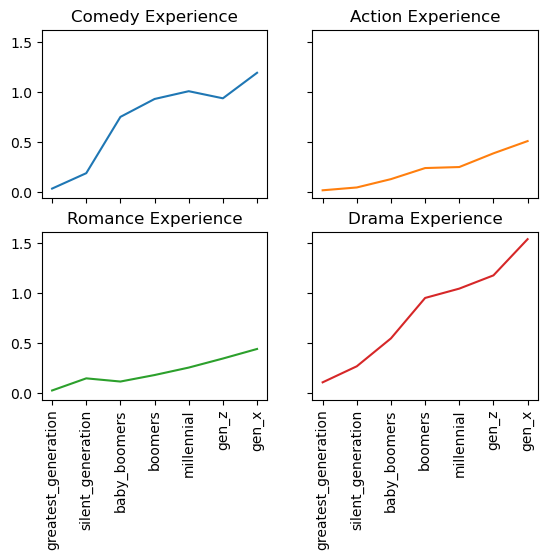

In [20]:
# Now lets look at every genre per area
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs[0, 0].plot(labels, comedy_avg)
axs[0, 0].set_title('Comedy Experience')
axs[0, 1].plot(labels, action_avg, 'tab:orange')
axs[0, 1].set_title('Action Experience')
axs[1, 0].plot(labels, romance_avg, 'tab:green')
axs[1, 0].set_title('Romance Experience')
axs[1, 1].plot(labels, drama_avg, 'tab:red')
axs[1, 1].set_title('Drama Experience')

axs[0,0].tick_params(axis='x', rotation= 90)
axs[0,1].tick_params(axis='x', rotation= 90)
axs[1,0].tick_params(axis='x', rotation= 90)
axs[1,1].tick_params(axis='x', rotation= 90)


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


Do more experienced actors/actresses tend to star in certain genres more frequently?

In [22]:
maxes = movies_actor.sort_values("exp_so_far", ascending=False)
from collections import defaultdict
actor_to_total_exp = defaultdict(int)

for row in maxes.iterrows():
    actor = row[1]["nconst"]
    votes = row[1]["exp_so_far"]

    actor_to_total_exp[actor] = max(votes, actor_to_total_exp[actor])

maxes = []
tops = []

greatest_maxes = greatest.sort_values("exp_so_far", ascending=False)
maxes.append(greatest_maxes)
greatest_top_1000 = defaultdict(int)
tops.append(greatest_top_1000)

silent_maxes = silent.sort_values("exp_so_far", ascending=False)
maxes.append(silent_maxes)
silent_top_1000 = defaultdict(int)
tops.append(silent_top_1000)

baby_maxes = baby_boomers.sort_values("exp_so_far", ascending=False)
maxes.append(baby_maxes)
baby_top_1000 = defaultdict(int)
tops.append(baby_top_1000)

boomers_maxes = boomers.sort_values("exp_so_far", ascending=False)
maxes.append(boomers_maxes)
boomers_top_1000 = defaultdict(int)
tops.append(boomers_top_1000)

millennial_maxes = millennial.sort_values("exp_so_far", ascending=False)
maxes.append(millennial_maxes)
millennial_top_1000 = defaultdict(int)
tops.append(millennial_top_1000)

gen_z_maxes = gen_z.sort_values("exp_so_far", ascending=False)
maxes.append(gen_z_maxes)
gen_z_top_1000 = defaultdict(int)
tops.append(gen_z_top_1000)

gen_x_maxes = gen_x.sort_values("exp_so_far", ascending=False)
maxes.append(gen_x_maxes)
gen_x_top_1000 = defaultdict(int)
tops.append(gen_x_top_1000)

def find_maxes(data, mapper):
    for row in data.iterrows():
        actor = row[1]["nconst"]
        exp = row[1]["exp_so_far"]
        
        if actor not in mapper:
            mapper[actor] = (0, 0, 0, 0, 0)
        
        if exp > mapper[actor][0]:
            mapper[actor] = (exp, row[1]["Drama_exp_so_far"], row[1]["Action_exp_so_far"], row[1]["Comedy_exp_so_far"], row[1]["Romance_exp_so_far"])
        # mapper[actor] = max(votes, mapper[actor])

for i in range(len(maxes)):
    # Find the max experienced actors for current generation
    find_maxes(maxes[i], tops[i])

    # Keep the top 1000
    tops[i] = sorted(tops[i].items(), key=lambda x: x[1],reverse=True)[:1000]

# We can already find interesting things

print("The top 1000 actor in the earliest generation has", tops[0][-1][1][0], "movies under his belt.")
print("The top 1000 actor in the latest generation has", tops[-1][-1][1][0], "movies under his belt. \n")

print("The top actor in the earliest generation has", tops[0][0][1][0], "movies under his belt.")
print("The top actor in the latest generation has", tops[-1][0][1][0], "movies under his belt. \n")

print("--> big discrepancy!")

The top 1000 actor in the earliest generation has 4 movies under his belt.
The top 1000 actor in the latest generation has 208 movies under his belt. 

The top actor in the earliest generation has 150 movies under his belt.
The top actor in the latest generation has 2069 movies under his belt. 

--> big discrepancy!


We generalize the previous code and add onto it so that we can generate the per genre movie experience distribution of the top 1000 actors per generation in 3 different cases:
- Only look at male actors
- Only look at female actors
- Combine both

In [26]:
def gender_based_analysis(gender_based = False, male = True):
    maxes = []
    tops = []

    if not gender_based:
        local_greatest = greatest
        local_silent = silent
        local_baby_boomers = baby_boomers
        local_boomers = boomers
        local_millennial = millennial
        local_gen_z = gen_z
        local_gen_x = gen_x
    elif gender_based and male:
        local_greatest = greatest.loc[greatest["gender"] == 0]
        local_silent = silent.loc[silent["gender"]== 0]
        local_baby_boomers = baby_boomers.loc[baby_boomers["gender"] == 0]
        local_boomers = boomers.loc[boomers["gender"] == 0]
        local_millennial = millennial.loc[millennial["gender"] == 0]
        local_gen_z = gen_z.loc[gen_z["gender"] == 0]
        local_gen_x = gen_x.loc[gen_x["gender"] == 0]
    elif gender_based and not male: # so female
        local_greatest = greatest.loc[greatest["gender"] == 1]
        local_silent = silent.loc[silent["gender"] == 1]
        local_baby_boomers = baby_boomers.loc[baby_boomers["gender"] == 1]
        local_boomers = boomers.loc[boomers["gender"] == 1]
        local_millennial = millennial.loc[millennial["gender"] == 1]
        local_gen_z = gen_z.loc[gen_z["gender"] == 1]
        local_gen_x = gen_x.loc[gen_x["gender"] == 1]

    greatest_maxes = local_greatest.sort_values("exp_so_far", ascending=False)
    maxes.append(greatest_maxes)
    greatest_top_1000 = defaultdict(int)
    tops.append(greatest_top_1000)

    silent_maxes = local_silent.sort_values("exp_so_far", ascending=False)
    maxes.append(silent_maxes)
    silent_top_1000 = defaultdict(int)
    tops.append(silent_top_1000)

    baby_maxes = local_baby_boomers.sort_values("exp_so_far", ascending=False)
    maxes.append(baby_maxes)
    baby_top_1000 = defaultdict(int)
    tops.append(baby_top_1000)

    boomers_maxes = local_boomers.sort_values("exp_so_far", ascending=False)
    maxes.append(boomers_maxes)
    boomers_top_1000 = defaultdict(int)
    tops.append(boomers_top_1000)

    millennial_maxes = local_millennial.sort_values("exp_so_far", ascending=False)
    maxes.append(millennial_maxes)
    millennial_top_1000 = defaultdict(int)
    tops.append(millennial_top_1000)

    gen_z_maxes = local_gen_z.sort_values("exp_so_far", ascending=False)
    maxes.append(gen_z_maxes)
    gen_z_top_1000 = defaultdict(int)
    tops.append(gen_z_top_1000)

    gen_x_maxes = local_gen_x.sort_values("exp_so_far", ascending=False)
    maxes.append(gen_x_maxes)
    gen_x_top_1000 = defaultdict(int)
    tops.append(gen_x_top_1000)

    def find_maxes(data, mapper):
        for row in data.iterrows():
            actor = row[1]["nconst"]
            exp = row[1]["exp_so_far"]
            
            if actor not in mapper:
                mapper[actor] = (0, 0, 0, 0, 0)
            
            if exp > mapper[actor][0]:
                mapper[actor] = (exp, row[1]["Drama_exp_so_far"], row[1]["Action_exp_so_far"], row[1]["Comedy_exp_so_far"], row[1]["Romance_exp_so_far"])
            # mapper[actor] = max(votes, mapper[actor])

    for i in range(len(maxes)):
        # Find the max experienced actors for current generation
        find_maxes(maxes[i], tops[i])

        # Keep the top 1000
        tops[i] = sorted(tops[i].items(), key=lambda x: x[1],reverse=True)[:1000]




    # We have the distribution of movie in all of them! 
    # Note that the order is (totalExperience, dramaExperience, actionExperience, comedyExperience, romanceExperience)

    # First step is to find the means of every genre for every era

    def find_mean(data, idx): #idx from 1 to 4 included
        return np.mean([x[1][idx] for x in data])

    means = [] # will have the same length as tops! 
    for top in tops:
        currMean = []
        for i in range(1, 5):
            currMean.append(find_mean(top, i))
        means.append(currMean)

    # means contains the average major movie genre experience for every generation
    # means[0] is the greatest_generation, means[-1] is gen_x
    # means[i] = (averageDrama, averageAction, averageComedy, averageRomance)


    # The x-locations for the genres
    x = np.arange(4)
    width = 0.12

    fig, ax = plt.subplots(1, figsize=(10, 10))

    greatest_means = means[0]
    rects1 = ax.bar(x - width * 2, greatest_means, width)

    silent_means = means[1]
    rects2 = ax.bar(x - width * 1, silent_means, width)

    baby_means = means[2]
    rects3 = ax.bar(x, baby_means, width)

    boomer_means = means[3]
    rects4 = ax.bar(x + width, boomer_means, width)

    millennial_means = means[4]
    rects5 = ax.bar(x + width * 2, millennial_means, width)

    gen_z_means = means[5]
    rects6 = ax.bar(x + width * 3, gen_z_means, width)

    gen_x_means = means[6]
    rects7 = ax.bar(x + width * 4, gen_x_means, width)

    if not gender_based:
        ax.set_title('Top 1000 actors genre experience distribution per generation')
    elif gender_based and male:
        ax.set_title('Top 1000 Male actors genre experience distribution per generation')
    elif gender_based and not male:
        ax.set_title('Top 1000 Female actors genre experience distribution per generation')
    ax.set_ylabel('Average acting experience in # of movies')
    ax.set_xticks(x+width)
    ax.set_xticklabels( ('Drama', 'Action', 'Comedy', 'Romance') )
    ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0], rects5[0], rects6[0], rects7[0]), labels )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom')

    plt.show()

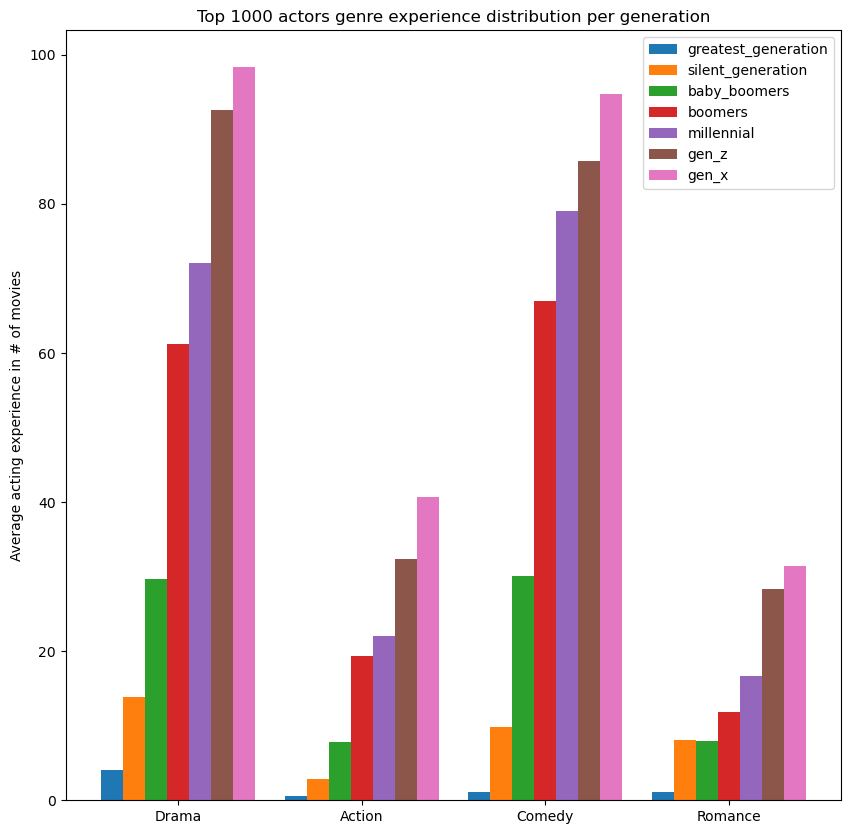

In [27]:
# Look at both genders
gender_based_analysis(gender_based=False)

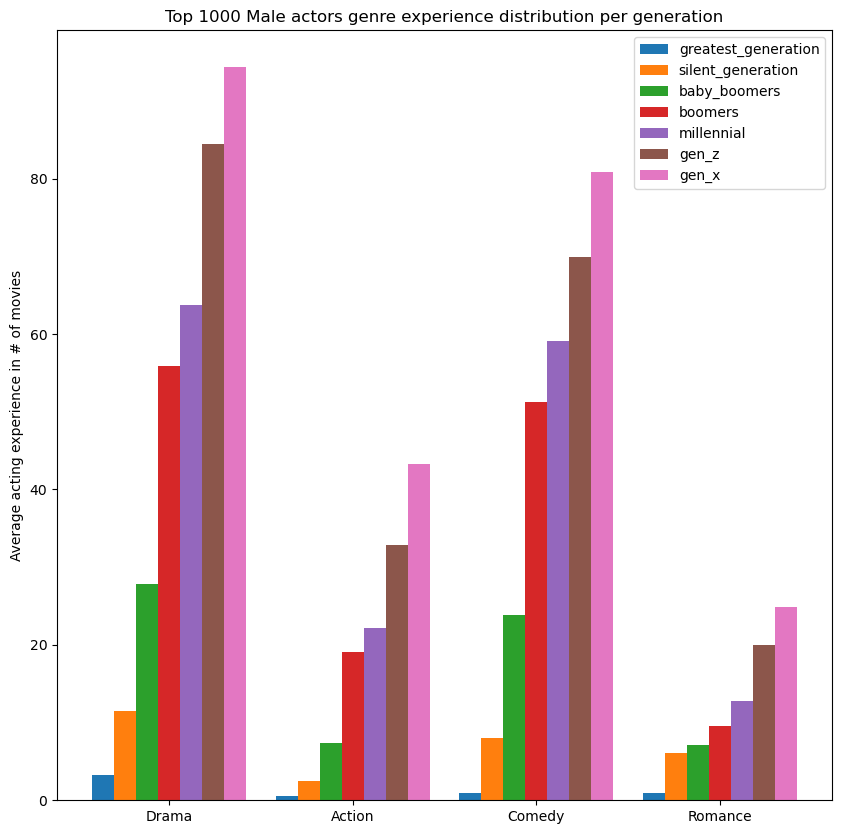

In [28]:
# Look at male actors only
gender_based_analysis(gender_based = True, male=True)

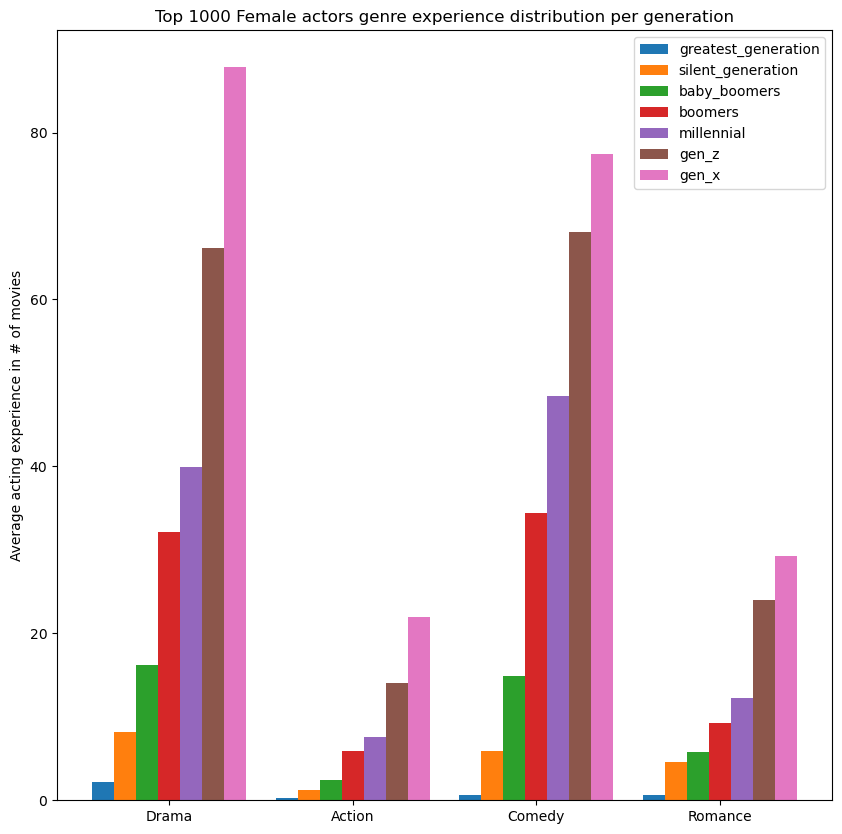

In [29]:
# Look at female actors only
gender_based_analysis(gender_based= True, male=False)

# Section 4 : Do Popular Actors stick to their best genres in the recent scenario?

For this analysis we look at the movies that fall into the genX category i.e. from 2013 onwards as defined earlier

<Figure size 640x480 with 0 Axes>

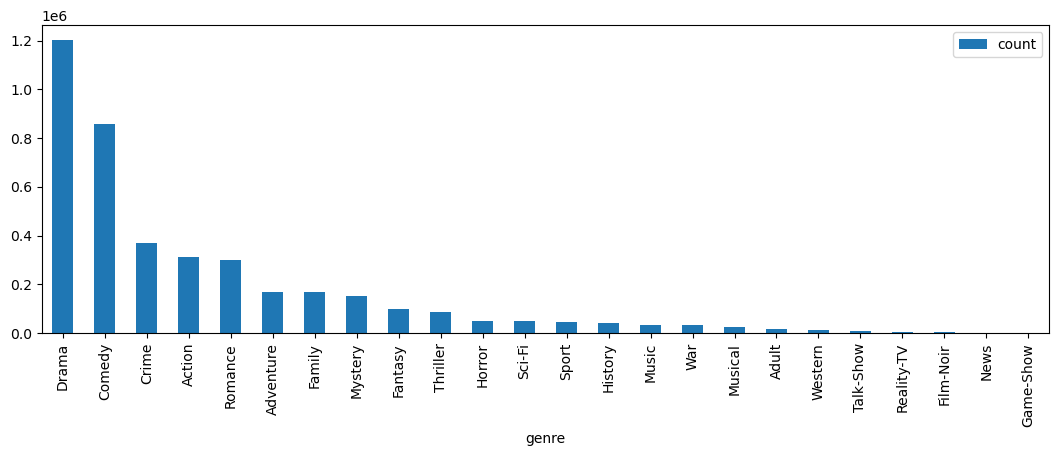

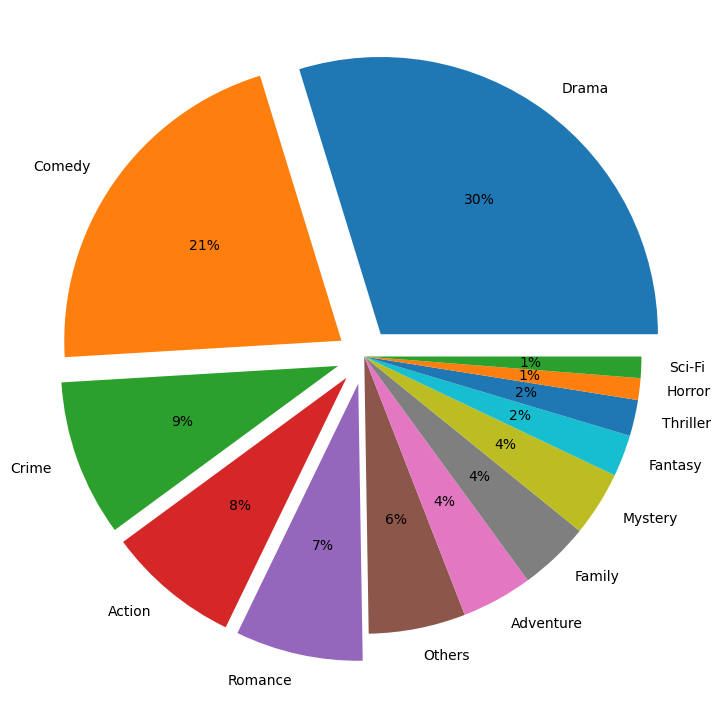

In [32]:
movies_popular = pd.read_csv("./data/actor_movie_combi.csv")

genres_popular, counts, mp = extract_genres(movies_popular)

# get genre experience for each movie-actor combination
movies_popular = genre_exp(mp)



In [33]:
mp = pd.read_csv("./data/actor_movie_combi_alive2.csv")

# very less correlation between the Average Imdb rating and votes 
print(mp['averageRating'].corr(mp['numVotes']))

0.020572124058708972


In [34]:
task3_df = mp[mp["startYear"]>=2013]

unique_actors = task3_df["nconst"].unique()
male_actors = task3_df[task3_df["gender"] == 0]["nconst"].unique()
female_actors = task3_df[task3_df["gender"] == 1]["nconst"].unique()
print("There's a total of", len(unique_actors), "unique actors.")

print("There's a total of", len(male_actors), "male actors.")
print("There's a total of", len(female_actors), "female actors.")

There's a total of 59673 unique actors.
There's a total of 33912 male actors.
There's a total of 25764 female actors.


In [61]:
task3_df = pd.read_csv("./data/Task3.csv")

# weighted average
c = ['Drama_exp_so_far', 'Action_exp_so_far',
       'Romance_exp_so_far', 'Comedy_exp_so_far', 'Adventure_exp_so_far',
       'Crime_exp_so_far', 'War_exp_so_far', 'Family_exp_so_far',
       'Mystery_exp_so_far']

#normal average
c2 =["averageRating", "numVotes"]

for x in c:
    values = task3_df[x]*task3_df.averageRating/10
    task3_df[x] = values

actors_genre_exp = pd.DataFrame()


actors_genre_exp[c] = task3_df.groupby("primaryName")[c].mean()
actors_genre_exp[c2] = task3_df.groupby("primaryName")[c2].mean()
actors_genre_exp["total_exp"] = task3_df.groupby("primaryName")["exp_so_far"].last()
actors_genre_exp["gender"] = task3_df.groupby("primaryName")["gender"].last()

# make vectors to represent the actors genre background in past movies
actors_genre_exp['all_genre_vector'] = actors_genre_exp[['Drama_exp_so_far',
       'Action_exp_so_far', 'Romance_exp_so_far', 'Comedy_exp_so_far',
       'Adventure_exp_so_far', 'Crime_exp_so_far', 'War_exp_so_far',
       'Family_exp_so_far', 'Mystery_exp_so_far']].values.tolist()
actors_genre_exp['major_genre_vector'] = actors_genre_exp[['Drama_exp_so_far',
       'Action_exp_so_far', 'Romance_exp_so_far', 'Comedy_exp_so_far',
       'Adventure_exp_so_far']].values.tolist()

# Calculating the diversity in an Actor's genre background from past movies using entropy

Using shannons entropy $H(p)$ which returns 0 if an actor has only been part of 1 genre, and highest value = 2.32 ($log_2(5)$) for a uniform distriubiton. [ Since we are using 5 major genres to construct the major genre vector]

In [62]:
def normal_variance(vv):

    #normalizing the vector
    vv = vv/np.sum(vv)

    return entropy(vv, base=2)

actors_genre_exp["genre_entropy"] = actors_genre_exp["major_genre_vector"].apply(normal_variance)

actors_genre_exp

,Drama_exp_so_far,Action_exp_so_far,Romance_exp_so_far,Comedy_exp_so_far,Adventure_exp_so_far,Crime_exp_so_far,War_exp_so_far,Family_exp_so_far,Mystery_exp_so_far,averageRating,numVotes,total_exp,gender,all_genre_vector,major_genre_vector,genre_entropy
primaryName,,,,,,,,,,,,,,,,
'Legs' Larry Smith,0.000000,0.00,0.000000,1.220000,0.000000,0.000000,0.0,0.61,0.000000,6.100000,18.000000,1,0,"[0.0, 0.0, 0.0, 1.22, 0.0, 0.0, 0.0, 0.61, 0.0]","[0.0, 0.0, 0.0, 1.22, 0.0]",0.000000
'The Jinni' Ra'Shawn Vass,0.590000,0.00,0.000000,0.590000,0.000000,0.000000,0.0,0.00,0.000000,5.900000,7.000000,0,0,"[0.5900000000000001, 0.0, 0.0, 0.5900000000000...","[0.5900000000000001, 0.0, 0.0, 0.5900000000000...",1.000000
'Weird Al' Yankovic,0.000000,0.00,0.000000,4.805000,0.000000,0.000000,0.0,0.00,0.000000,6.300000,160.000000,21,0,"[0.0, 0.0, 0.0, 4.805, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 4.805, 0.0]",0.000000
2 Chainz,0.000000,0.00,0.000000,0.390000,0.000000,0.000000,0.0,0.00,0.000000,3.900000,87.000000,0,0,"[0.0, 0.0, 0.0, 0.39, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.39, 0.0]",0.000000
360,0.000000,0.88,0.000000,0.880000,0.000000,0.880000,0.0,0.00,0.000000,8.800000,6.000000,0,0,"[0.0, 0.8800000000000001, 0.0, 0.8800000000000...","[0.0, 0.8800000000000001, 0.0, 0.8800000000000...",1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ünal Yeter,0.000000,0.00,0.335714,2.255714,0.000000,0.000000,0.0,0.00,0.000000,4.471429,285.142857,7,0,"[0.0, 0.0, 0.33571428571428574, 2.255714285714...","[0.0, 0.0, 0.33571428571428574, 2.255714285714...",0.556197
Þorsteinn Bachmann,20.279231,0.00,0.000000,4.260769,0.057308,2.578462,0.0,0.00,2.719231,6.873077,1937.538462,58,0,"[20.279230769230768, 0.0, 0.0, 4.2607692307692...","[20.279230769230768, 0.0, 0.0, 4.2607692307692...",0.688113
Þorsteinn Guðmundsson,5.364000,0.00,1.480000,2.444000,0.000000,3.884000,0.0,0.00,0.000000,7.400000,160.200000,14,0,"[5.364, 0.0, 1.48, 2.444, 0.0, 3.8840000000000...","[5.364, 0.0, 1.48, 2.444, 0.0]",1.386489


# Using number of votes to decide the IMDB rating of their past movies as a metric of popularity

In [68]:
# top 10 popular actors based on votes
df = actors_genre_exp[actors_genre_exp["total_exp"]>40]
popular_male = df[df["gender"] == 0].nlargest(10, "numVotes")

popular_female = df[df["gender"] == 1].nlargest(10, "numVotes")

# How do these Actors measure up in terms of their genre entropy?

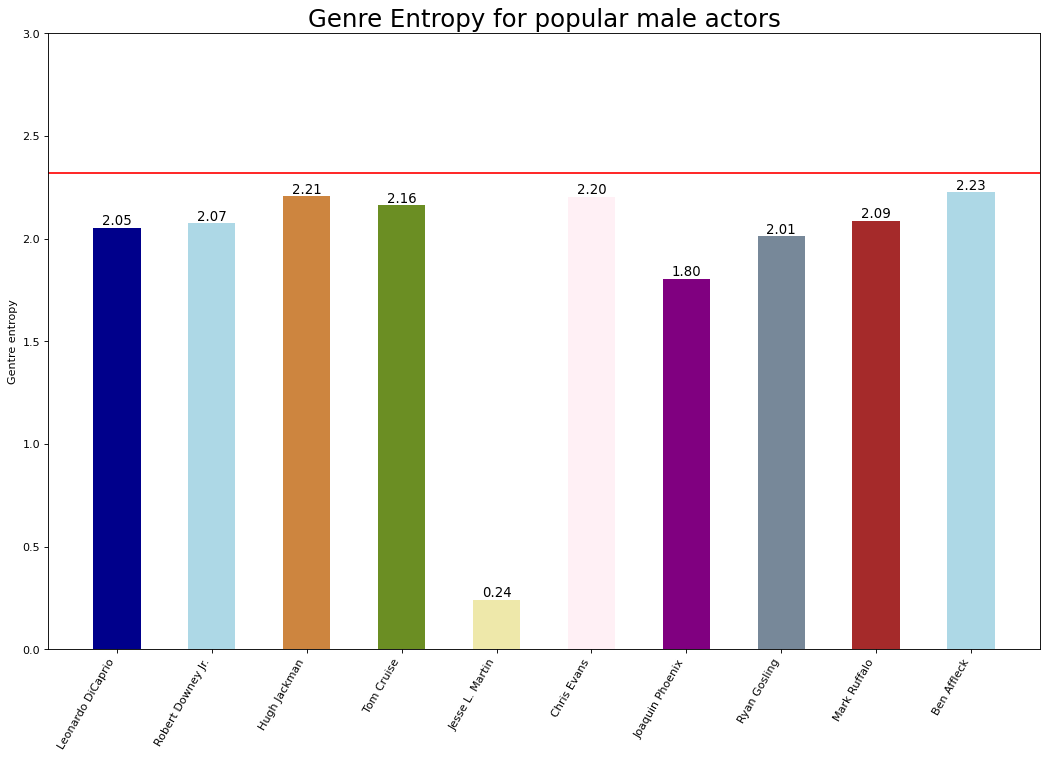

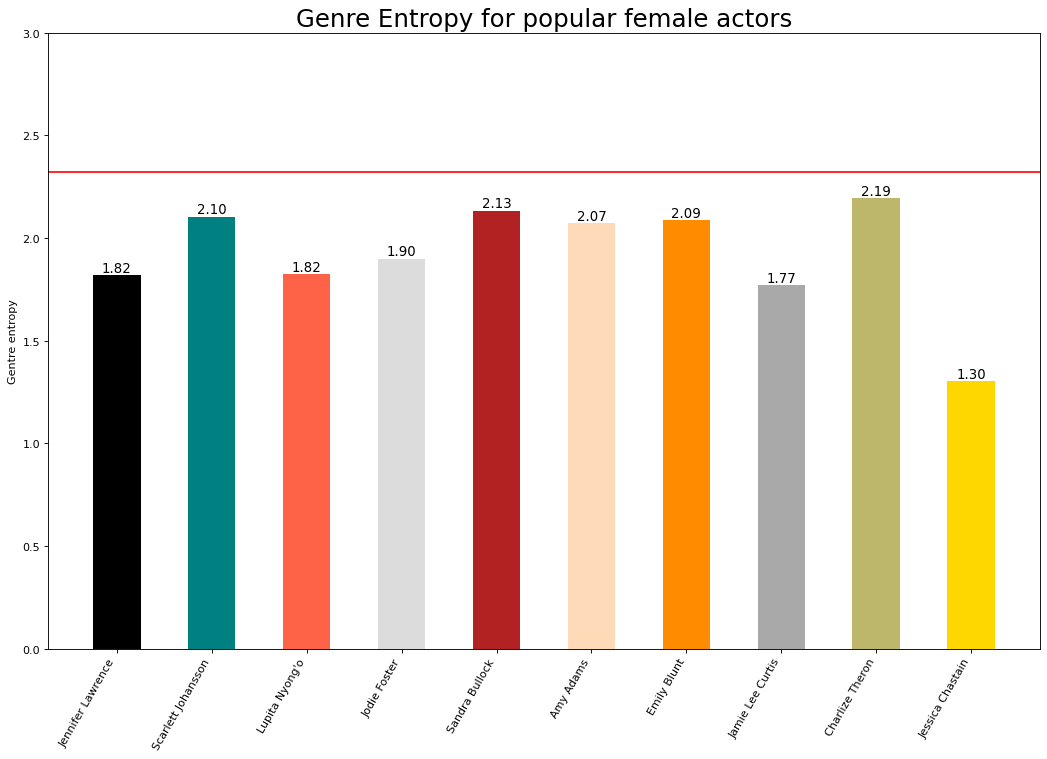

In [70]:
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)


def plot_entropy(dataset, s):

    n = len(dataset)
    c = random.choices(all_colors, k=n)


    # plt.bar(popular_male.index, popular_male["genre_entropy"])
    # # Rotation of the bars names
    # plt.xticks( rotation=90)


    # Plot Bars
    plt.figure(figsize=(16,10), dpi= 80)
    plt.bar(dataset.index, dataset["genre_entropy"], color=c, width=.5)
    for i, val in enumerate(dataset['genre_entropy'].values):
        plt.text(i, val, "{:.2f}".format(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

    plt.axhline(y = 2.32, color = 'r', linestyle = '-')

    # Decoration
    plt.gca().set_xticklabels(dataset.index, rotation=60, horizontalalignment= 'right')
    plt.title("Genre Entropy for popular "+s+" actors", fontsize=22)
    plt.ylabel('Gentre entropy')
    plt.ylim(0, 3)
    plt.show()

plot_entropy(popular_male, s="male")
plot_entropy(popular_female, s="female")

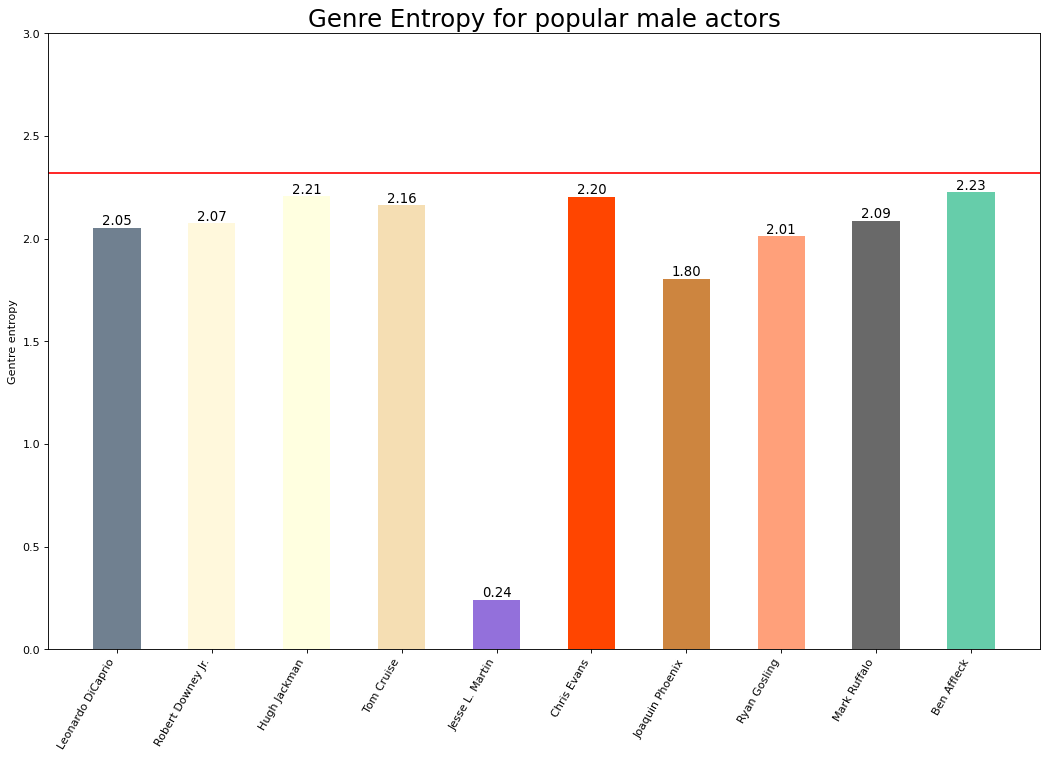

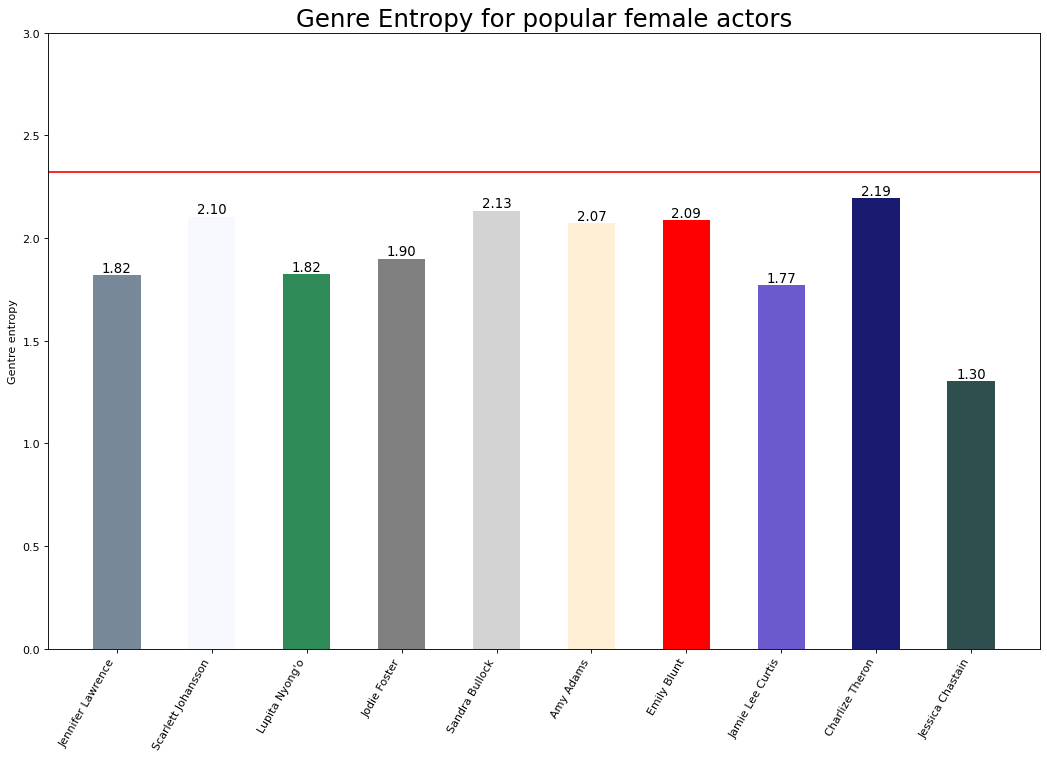

In [72]:
# top 10 popular actors based on votes and filtered based on experience (no "one hit wonders")

df = actors_genre_exp[actors_genre_exp["total_exp"]>40]
popular_male = df[df["gender"] == 0].nlargest(10, "numVotes")

popular_female = df[df["gender"] == 1].nlargest(10, "numVotes")

plot_entropy(popular_male, s="male")
plot_entropy(popular_female, s="female")